In [1]:
import pandas as pd
from ast import literal_eval
from rdkit import DataStructs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
from ast import literal_eval
from scipy import stats

In [2]:
df_fp = pd.read_pickle("../../results/schembl_summs_v5_final_fp_bitvec.pkl")
df_fp["summarizations"] = df_fp["summarizations"].apply(literal_eval)

null vs. graph: t-test independent samples, P_val:3.276e-23 t=-1.014e+01


<Figure size 640x480 with 0 Axes>

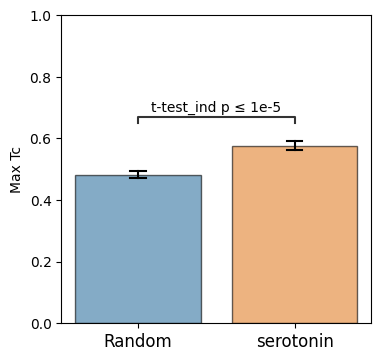

In [3]:
# for term in ["antiviral", "nucleoside", "hcv", "electroluminescence", "opioid", "perfume", "cannabinoid", "polymer", "protease", "cb1", "luminescence"]:
# for term in ["5-ht", "electroluminescence", "hcv"]:
for term in ["serotonin"]:
# for term in ["perfume",]:
    df_term = df_fp[df_fp["summarizations"].map(lambda x: any(term == word for word in x))].reset_index(drop=True)
    df_rand = df_fp.sample(n=len(df_term), random_state=42).reset_index(drop=True)
    fp_tanimoto = np.zeros(len(df_term))
    fp_tanimoto_rand = np.zeros(len(df_term))
    for i in range(len(df_term)):
        # calculate the max bulk tanimoto similarity between the query and the other molecules
        fp_tanimoto[i] = max(DataStructs.BulkTanimotoSimilarity(df_term["fingerprint"].iloc[i], df_term.drop(i, axis=0).reset_index(drop=True)["fingerprint"]))
        fp_tanimoto_rand[i] = max(DataStructs.BulkTanimotoSimilarity(df_rand["fingerprint"].iloc[i], df_rand.drop(i, axis=0).reset_index(drop=True)["fingerprint"]))

    fp_tanimoto_mean = np.mean(fp_tanimoto)
    fp_tanimoto_std = np.std(fp_tanimoto)
    fp_tanimoto_conf = 1.96 * fp_tanimoto_std / np.sqrt(len(fp_tanimoto))
    fp_tanimoto_rand_mean = np.mean(fp_tanimoto_rand)
    fp_tanimoto_rand_std = np.std(fp_tanimoto_rand)
    fp_tanimoto_rand_conf = 1.96 * fp_tanimoto_rand_std / np.sqrt(len(fp_tanimoto_rand))

    plt.clf()
    plot_df = pd.DataFrame(columns=['group', 'value'])
    plot_df = pd.concat([plot_df, pd.DataFrame({'group': 'null', 'value': fp_tanimoto_rand})])
    plot_df = pd.concat([plot_df, pd.DataFrame({'group': 'graph', 'value': fp_tanimoto})])
    fig, ax = plt.subplots(figsize=(4, 4))

    # add first plot. Make conf interval have caps. Set confidence interval to 95% (variable)
    sns.barplot(x='group', y='value', data=plot_df, color='white', ax=ax, palette=sns.color_palette(), dodge=False, alpha=0.6, ec='k', linewidth=1, capsize=0.1, errwidth=1.5, errcolor='k', errorbar=('ci', 95))

    # remove xlabel
    ax.set_xlabel('')
    ax.set_ylabel(f'Max Tc')
    # set x axis labels
    ax.set_xticklabels([f'Random', f'{term}'], fontsize=12)
    ax.set_ylim(0, 1)

    # prep data for statistical test
    # add statistical annotations
    annotator = Annotator(data=plot_df, x='group', y='value', pairs = [('null', 'graph')], ax=ax)
    annotator.configure(test="t-test_ind", text_format='simple', loc='inside', verbose=2)
    # line up width with means of distributions
    annotator.apply_test()
    annotator.annotate()


    plt.savefig(f'tsne_primary_stat_plots/term_{term}_max_tc.png', dpi=300, bbox_inches='tight')

    # write close_terms, means, and stds to file
    with open(f'tsne_primary_stat_plots/term_{term}_max_tc.txt', 'w') as f:
        f.write(f'Primary Term: {term}\n')
        f.write(f'n mols with term: {len(df_term)}\n')
        f.write(f'Mean: {fp_tanimoto_mean}\n')
        f.write(f'Std: {fp_tanimoto_std}\n')
        f.write(f'95% Conf: {fp_tanimoto_conf}\n')
        f.write(f'n random points sampled: {len(df_term)}\n')
        f.write(f'Random mean: {fp_tanimoto_rand_mean}\n')
        f.write(f'Random std: {fp_tanimoto_rand_std}\n')
        f.write(f'Random 95% conf: {fp_tanimoto_rand_conf}\n')


In [4]:
# load all labels
with open("../../results/all_labels.txt", "r") as f:
    all_labels = f.read().splitlines()

In [5]:
t_stats = []
p_vals = []
n_mols = []

# for term in all_labels[-2:]:
for count, term in enumerate(["5-ht","opioid"]):
    print(f"{count}/{len(all_labels)} -- {term}", end="\r")
    df_term = df_fp[df_fp["summarizations"].map(lambda x: any(term == word for word in x))].reset_index(drop=True)
    df_rand = df_fp.sample(n=len(df_term), random_state=42).reset_index(drop=True)
    fp_tanimoto = np.zeros(len(df_term))
    fp_tanimoto_rand = np.zeros(len(df_term))
    for i in range(len(df_term)):
        # calculate the max bulk tanimoto similarity between the query and the other molecules
        fp_tanimoto[i] = max(DataStructs.BulkTanimotoSimilarity(df_term["fingerprint"].iloc[i], df_term.drop(i, axis=0).reset_index(drop=True)["fingerprint"]))
        fp_tanimoto_rand[i] = max(DataStructs.BulkTanimotoSimilarity(df_rand["fingerprint"].iloc[i], df_rand.drop(i, axis=0).reset_index(drop=True)["fingerprint"]))

    # compute t test p value
    t_stat, p_val = stats.ttest_ind(fp_tanimoto, fp_tanimoto_rand)
    t_stats.append(t_stat)
    p_vals.append(p_val)
    n_mols.append(len(df_term))

In [6]:
df_p_values = pd.DataFrame({"label": all_labels[-2:], "t_stat": t_stats, "p_val": p_vals, "n_mols": n_mols})

In [7]:
df_p_values.to_csv("primary_label_t_test.csv", index=False)